In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons

We define our flow network:

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim+1, h),
            nn.SiLU(),
            nn.Linear(h, h),
            nn.SiLU(),
            nn.Linear(h, h),
            nn.SiLU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        x_mid = x_t + self(x_t, t_start) * (t_end - t_start) / 2
        v_mid = self(x_mid, t_start + (t_end - t_start) / 2)

        return x_t + (t_end - t_start) * v_mid

**Training**

We'll train a flow to generate concentric circles like the following:

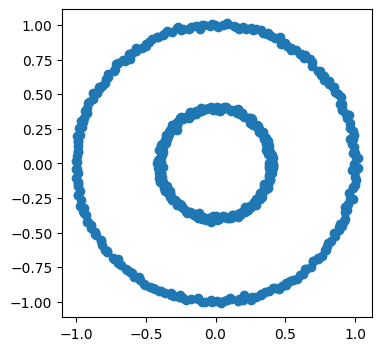

In [3]:
x_1 = Tensor(make_circles(n_samples=512, factor = 0.4, noise = 0.01)[0])

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
_ = plt.scatter(x_1[:,0], x_1[:,1])

We'll use Adam and the MSE loss:

In [4]:
flow = Flow(h = 128)
optimizer = torch.optim.Adam(flow.parameters(), lr = 1e-2)
loss = nn.MSELoss()

In [5]:
for step in range(20000):
    x_1 = Tensor(make_circles(n_samples=512, factor = 0.4, noise = 0.01)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)

    x_t = (1 - t) * x_0 + t * x_1

    dx_t = x_1 - x_0

    optimizer.zero_grad()

    pred = flow(x_t, t)

    l = loss(pred, dx_t)
    l.backward()

    if step % 1000 == 0:
        print(step)
        print(l)

    optimizer.step()

0
tensor(1.3524, grad_fn=<MseLossBackward0>)
1000
tensor(0.8708, grad_fn=<MseLossBackward0>)
2000
tensor(0.7841, grad_fn=<MseLossBackward0>)
3000
tensor(0.7523, grad_fn=<MseLossBackward0>)
4000
tensor(0.7812, grad_fn=<MseLossBackward0>)
5000
tensor(0.8189, grad_fn=<MseLossBackward0>)
6000
tensor(0.7647, grad_fn=<MseLossBackward0>)
7000
tensor(0.7891, grad_fn=<MseLossBackward0>)
8000
tensor(0.7419, grad_fn=<MseLossBackward0>)
9000
tensor(0.7421, grad_fn=<MseLossBackward0>)
10000
tensor(0.7481, grad_fn=<MseLossBackward0>)
11000
tensor(0.7439, grad_fn=<MseLossBackward0>)
12000
tensor(0.7533, grad_fn=<MseLossBackward0>)
13000
tensor(0.7495, grad_fn=<MseLossBackward0>)
14000
tensor(0.8188, grad_fn=<MseLossBackward0>)
15000
tensor(0.7378, grad_fn=<MseLossBackward0>)
16000
tensor(0.7940, grad_fn=<MseLossBackward0>)
17000
tensor(0.8411, grad_fn=<MseLossBackward0>)
18000
tensor(0.7825, grad_fn=<MseLossBackward0>)
19000
tensor(0.7673, grad_fn=<MseLossBackward0>)


**Sampling**

Now that the flow is trained, we can generate samples:

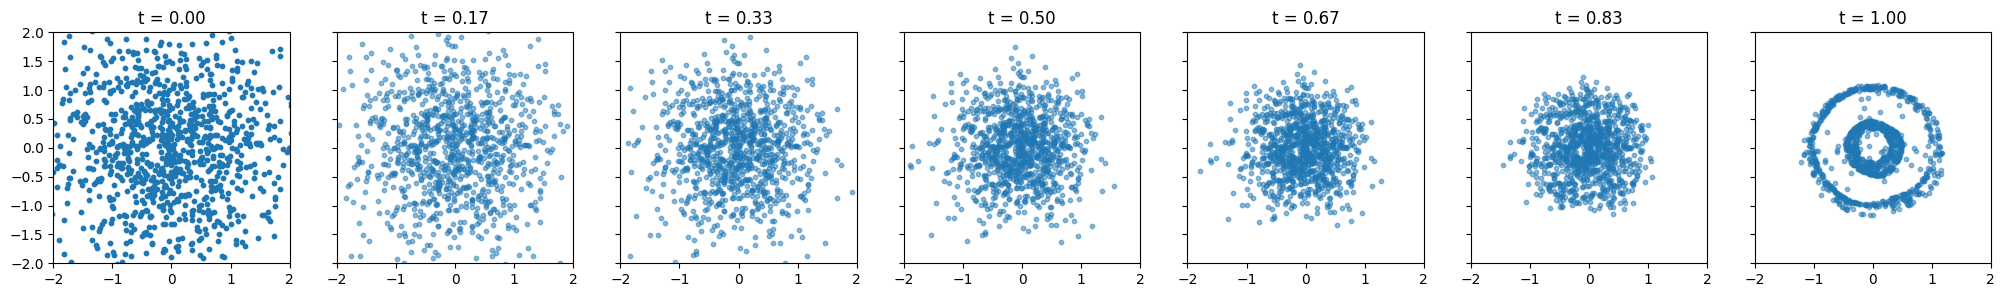

In [6]:
num_samples = 1024

x = torch.randn(num_samples, 2)

n_steps = 6
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

fig, ax = plt.subplots(1, n_steps + 1, figsize = (25, 3), sharex = True, sharey = True)
_ = ax[0].scatter(x.detach()[:,0], x.detach()[:,1], s = 10)
_ = ax[0].set_title(f't = {time_steps[0]:.2f}')
_ = ax[0].set_xlim(-2, 2)
_ = ax[0].set_ylim(-2, 2)

for t in range(n_steps):
    x = flow.step(x, time_steps[t], time_steps[t+1])
    _ = ax[t+1].scatter(x.detach()[:,0], x.detach()[:,1], s = 10, alpha = 0.5)
    _ = ax[t+1].set_title(f't = {time_steps[t+1]:.2f}')
    _ = ax[t+1].set_xlim(-2, 2)
    _ = ax[t+1].set_ylim(-2, 2)